In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from getdist import loadMCSamples
from getdist import MCSamples, plots
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
from scipy.stats import norm, chi2
%matplotlib inline

In [2]:
WORK_DIR = Path('/global/homes/s/siyizhao/projects/fihobi/HIP/test/QSO_2.8_3.5')

## version 0.1: Gaussian Summarize 100 Bestfits

In [3]:
data = pd.read_csv(WORK_DIR / 'HIP/fitp_mocks_fnl100_DESI_b-p.csv')
data

,i,fnl_loc,p,b1,sn0,sigmas
0,0,100.0,1.904445,4.095708,0.423173,8.932602
1,1,100.0,1.961433,4.046985,0.462925,10.227059
2,2,100.0,2.061079,4.033693,0.456466,10.593453
3,3,100.0,1.932037,4.029731,0.408343,8.781803
4,4,100.0,1.959245,4.049489,0.483315,10.462307
...,...,...,...,...,...,...
95,95,100.0,1.904353,4.115234,0.426944,9.802685
96,96,100.0,1.596038,4.099006,0.421011,9.728568
97,97,100.0,1.792663,4.074866,0.478165,10.233658
98,98,100.0,1.992016,4.153412,0.454517,10.184708


In [4]:
p_mean = np.mean(data['p'])
p_err_dof0 = np.std(data['p'], ddof=0) 
p_err_dof1 = np.std(data['p'], ddof=1) 
p_mean, p_err_dof0, p_err_dof1

(1.8841338519076871, 0.10508559527225553, 0.1056149970876415)

In [5]:
samples = data[['p', 'b1', 'sn0', 'sigmas']].to_numpy()
gds = MCSamples(samples=samples, names=['p', 'b1', 'sn0', 'sigmas'], labels=['p', 'b_1', 'SN_0', '\\Sigma_s'])

Removed no burn in


In [6]:
mean = gds.getMeans()
print("Mean parameters:", mean)
cov = gds.getCovMat().matrix
print("Covariance matrix:\n", cov)
errors = np.sqrt(np.diag(cov))
print("1-sigma errors:", errors)
print("Statistical of p:", p_mean, "+/-", p_err_dof1)

Mean parameters: [1.88413385 4.08198875 0.44126112 9.72338938]
Covariance matrix:
 [[ 1.10429823e-02  7.12436461e-04  1.72664773e-03  3.10559743e-02]
 [ 7.12436461e-04  1.40372294e-03 -1.45823976e-04 -4.43763716e-03]
 [ 1.72664773e-03 -1.45823976e-04  2.10961087e-03  4.34756883e-02]
 [ 3.10559743e-02 -4.43763716e-03  4.34756883e-02  1.01864560e+00]]
1-sigma errors: [0.1050856  0.03746629 0.0459305  1.00927974]
Statistical of p: 1.8841338519076871 +/- 0.1056149970876415


In [7]:
def sample_multivariate_gaussian(mean, cov, nsamples=10000, seed=None):
    rng = np.random.default_rng(seed)
    samples = rng.multivariate_normal(mean, cov, size=nsamples)
    return samples

# 示例调用
samplesG = sample_multivariate_gaussian(mean, cov)
gds_gaussian = MCSamples(samples=samplesG, names=['p', 'b1', 'sn0', 'sigmas'], labels=['p', 'b_1', 'SN_0', '\\Sigma_s'])

Removed no burn in


In [8]:
def draw_gaussian_ellipse(ax, mean_vec, cov_mat, n_std=1.0, **kwargs):
    # Draw a confidence ellipse for a 2D Gaussian defined by mean and covariance
    vals, vecs = np.linalg.eigh(cov_mat)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * n_std * np.sqrt(vals)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    ellipse = Ellipse(xy=mean_vec, width=width, height=height, angle=angle, fill=False, **kwargs)
    ax.add_patch(ellipse)


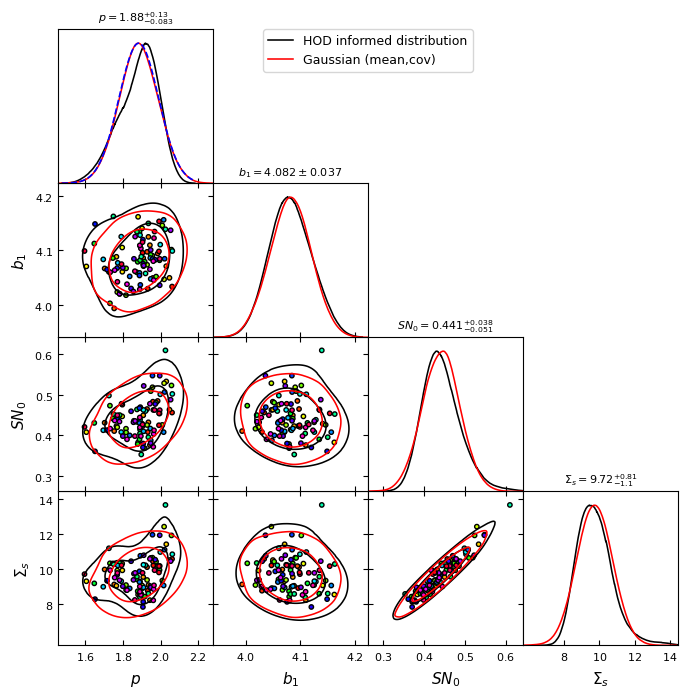

In [9]:
g = plots.get_subplot_plotter()
g.settings.linewidth_contour = 2.0   # contour width
g.settings.linewidth = 2.0           # 1D curve width
# g.triangle_plot([gds, gds_gaussian], filled=False, title_limit=1)
g.triangle_plot([gds, gds_gaussian], legend_labels=['HOD informed distribution', 'Gaussian (mean,cov)'], filled=False, title_limit=1)
nparam = samples.shape[1]
idx = np.arange(samples.shape[0])
cmap = 'hsv'
ellipse_levels = [np.sqrt(chi2.ppf(0.68, df=2)), np.sqrt(chi2.ppf(0.95, df=2))]  # 68%/95% for 2D Gaussian
for i in range(nparam):
    # # 1D theoretical Gaussian overlay (scaled to getdist KDE height)
    # ax_diag = g.subplots[i][i]
    # d1 = gds.get1DDensity(i)
    # x = d1.x
    # pdf = norm.pdf(x, loc=mean[i], scale=errors[i])
    # scale = d1.P.max() / pdf.max() if pdf.max() > 0 else 1.0
    # ax_diag.plot(x, pdf * scale, color='blue', lw=1.2)
    for j in range(i):
        ax = g.subplots[i][j]
        ax.scatter(samples[:, j], samples[:, i], c=idx, cmap=cmap, s=10, edgecolors='k')
#         mu = np.array([mean[j], mean[i]])
#         cov_sub = cov[np.ix_([j, i], [j, i])]
#         for ns in ellipse_levels:
#             draw_gaussian_ellipse(ax, mu, cov_sub, n_std=ns, edgecolor='blue', lw=1.2, alpha=0.8)
#         ax.scatter(mu[0], mu[1], color='black', s=25, marker='x')
ax = g.subplots[0][0]
d1 = gds.get1DDensity(0)
x = d1.x
pdf = norm.pdf(x, loc=p_mean, scale=p_err_dof1)
scale = d1.P.max() / pdf.max() if pdf.max() > 0 else 1.0
ax.plot(x, pdf * scale, '--', color='blue', lw=1.2)
# 统一图例放到整张图外侧
# handles, labels = g.subplots[0][0].get_legend_handles_labels()
# g.fig.legend([], ['HOD informed distribution', 'Gaussian (mean,cov)'], loc='upper right', bbox_to_anchor=(0.9, 0.9), frameon=False)

## Version 1.0: Combine 100 Chains

In [10]:
import pandas as pd
import os
import matplotlib.colors as mcolors

In [11]:
cmap = plt.get_cmap('hsv')
norm = mcolors.Normalize()

colors = cmap(norm(idx))

In [12]:
rows = []
for i in range(100):
    ODIR = WORK_DIR / "HIP" / "mocks" / f"r{i}"
    fn_chain = os.path.realpath(ODIR / "chain_zeus")
    rows.append({'i': i, 'fn_chain': str(fn_chain)})
df_chains = pd.DataFrame(rows)
df_chains.to_csv(WORK_DIR / 'HIP/fitp_mocks_fnl100_DESI_b-p_chains.csv', index=False)


In [13]:
data = pd.read_csv(WORK_DIR / 'HIP/fitp_mocks_fnl100_DESI_b-p_chains.csv')
data

,i,fn_chain
0,0,/pscratch/sd/s/siyizhao/fihobi/HIP_test/QSO_2....
1,1,/pscratch/sd/s/siyizhao/fihobi/HIP_test/QSO_2....
2,2,/pscratch/sd/s/siyizhao/fihobi/HIP_test/QSO_2....
3,3,/pscratch/sd/s/siyizhao/fihobi/HIP_test/QSO_2....
4,4,/pscratch/sd/s/siyizhao/fihobi/HIP_test/QSO_2....
...,...,...
95,95,/pscratch/sd/s/siyizhao/fihobi/HIP_test/QSO_2....
96,96,/pscratch/sd/s/siyizhao/fihobi/HIP_test/QSO_2....
97,97,/pscratch/sd/s/siyizhao/fihobi/HIP_test/QSO_2....
98,98,/pscratch/sd/s/siyizhao/fihobi/HIP_test/QSO_2....


In [14]:
num = 100
method = 'resampling'
# method = 'norm_weight'
resample_number = 10000
chain_all = []
for i in range(num):
    chain = loadMCSamples(data['fn_chain'][i])
    if i==0:
        names = chain.getParamNames().names
        labels = [p.label for p in chain.getParamNames().names]
    weights = chain.weights
    chain_length = len(weights)
    if chain_length != np.sum(weights):
        print(i, "Sum of weights != chain length")
    ## resampling
    if method=='resampling':
        if chain_length < resample_number:
            print("Warning: chain length < ", resample_number, ", consider lower resample number!")
        prob = weights / np.sum(weights)
        counts = np.random.multinomial(resample_number, prob)
        resampled_samples = np.repeat(chain.samples, counts, axis=0)
        new_chain = MCSamples(samples=resampled_samples, names=[p.name for p in names])
    elif method=='norm_weight':
        new_chain = chain.copy()
        new_chain.weights = weights / np.sum(weights) * 200000
    chain_all.append(new_chain)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

In [15]:
chain_length_all = []
for i in range(num):
    weights = chain_all[i].weights
    chain_length = len(weights)
    print(i, chain_length, np.sum(weights))
    chain_length_all.append(chain_length)

0 10000 10000.0
1 10000 10000.0
2 10000 10000.0
3 10000 10000.0
4 10000 10000.0
5 10000 10000.0
6 10000 10000.0
7 10000 10000.0
8 10000 10000.0
9 10000 10000.0
10 10000 10000.0
11 10000 10000.0
12 10000 10000.0
13 10000 10000.0
14 10000 10000.0
15 10000 10000.0
16 10000 10000.0
17 10000 10000.0
18 10000 10000.0
19 10000 10000.0
20 10000 10000.0
21 10000 10000.0
22 10000 10000.0
23 10000 10000.0
24 10000 10000.0
25 10000 10000.0
26 10000 10000.0
27 10000 10000.0
28 10000 10000.0
29 10000 10000.0
30 10000 10000.0
31 10000 10000.0
32 10000 10000.0
33 10000 10000.0
34 10000 10000.0
35 10000 10000.0
36 10000 10000.0
37 10000 10000.0
38 10000 10000.0
39 10000 10000.0
40 10000 10000.0
41 10000 10000.0
42 10000 10000.0
43 10000 10000.0
44 10000 10000.0
45 10000 10000.0
46 10000 10000.0
47 10000 10000.0
48 10000 10000.0
49 10000 10000.0
50 10000 10000.0
51 10000 10000.0
52 10000 10000.0
53 10000 10000.0
54 10000 10000.0
55 10000 10000.0
56 10000 10000.0
57 10000 10000.0
58 10000 10000.0
59 1000

In [16]:
np.min(chain_length_all), np.max(chain_length_all)

(10000, 10000)

In [17]:
# combine all chains and plot their joint distribution
samples_list = [c.samples for c in chain_all]
weights_list = [c.weights if c.weights is not None else np.ones(len(c.samples)) for c in chain_all]
loglikes_list = [c.loglikes if c.loglikes is not None else None for c in chain_all]
samples_combined = np.vstack(samples_list)
weights_combined = np.hstack(weights_list)
# loglikes_combined = None if all(ll is None for ll in loglikes_list) else np.hstack([ll if ll is not None else np.zeros(len(chain_all[0].samples)) for ll in loglikes_list])
gds_all = MCSamples(samples=samples_combined, names=[p.name for p in names], labels=labels, weights=weights_combined)
g = plots.get_subplot_plotter()
g.settings.linewidth_contour = 2.0
g.settings.linewidth = 2.0

Removed no burn in


In [18]:
np.average(gds_all.samples[:, 0]), np.average(gds_all.samples[:, 0], weights=gds_all.weights)

(1.9077814355680227, 1.9077814355680227)

In [19]:
mean = gds_all.getMeans()
print("Mean parameters:", mean)
cov = gds_all.getCovMat().matrix
print("Covariance matrix:\n", cov)
errors = np.sqrt(np.diag(cov))
print("1-sigma errors:", errors)
print("Statistical of p bestfits:", p_mean, "+/-", p_err_dof1)

Mean parameters: [ 1.90778144e+00  4.10116830e+00  3.91878025e-01  8.59582669e+00
 -1.87148624e+01 -1.87148623e+01 -8.76786657e-08]
Covariance matrix:
 [[ 1.31893100e-01  2.06152273e-02  1.03735891e-02  4.28122113e-01
  -1.11430931e-01 -1.11430927e-01 -4.66980205e-09]
 [ 2.06152273e-02  6.41714384e-03 -1.87954418e-03  3.29706235e-03
  -1.43616338e-02 -1.43616342e-02  4.15591798e-10]
 [ 1.03735891e-02 -1.87954418e-03  2.17889448e-02  5.17480339e-01
   5.09662660e-03  5.09663472e-03 -8.12752696e-09]
 [ 4.28122113e-01  3.29706235e-03  5.17480339e-01  1.31977818e+01
   2.91153955e-01  2.91154148e-01 -1.92823882e-07]
 [-1.11430931e-01 -1.43616338e-02  5.09662660e-03  2.91153955e-01
   3.94038938e+00  3.94038937e+00  4.60264435e-09]
 [-1.11430927e-01 -1.43616342e-02  5.09663472e-03  2.91154148e-01
   3.94038937e+00  3.94038937e+00  4.60264117e-09]
 [-4.66980205e-09  4.15591798e-10 -8.12752696e-09 -1.92823882e-07
   4.60264435e-09  4.60264117e-09  3.18470588e-15]]
1-sigma errors: [3.63170896e

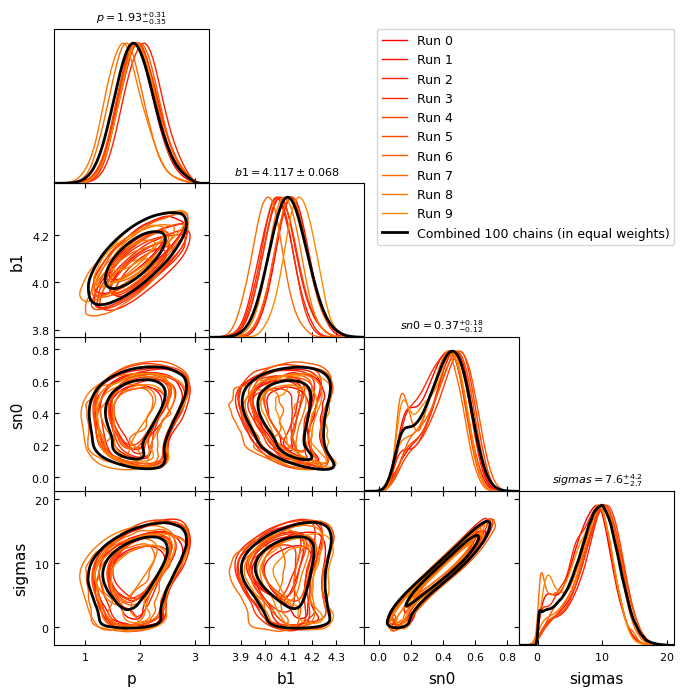

In [20]:
plot_num = 10
all_samples = chain_all[:plot_num] + [gds_all]
line_args_list = [{'color':colors[i], 'ls': '-', 'lw':1.0} for i in range(plot_num)] + [{'color':'black', 'ls': '-', 'lw':2.0}]
legend_labels = [f'Run {i}' for i in range(plot_num)] + ['Combined 100 chains (in equal weights)']
g = plots.get_subplot_plotter()
g.triangle_plot(all_samples,
                params=['p', 'b1', 'sn0', 'sigmas'],
                filled=False,
                legend_labels=legend_labels,
                legend_loc='upper right',
                contour_args=line_args_list.copy(),
                line_args=line_args_list.copy(),
                title_limit=1
            )
